In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [ ]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 SepsisLabel
0.0    39402
1.0    13134
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [ ]:
# split
train_df, test_df = split_train_test_data_v2(data)

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=drop_column, inplace=True)
/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=drop_column, inplace=True)


In [4]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((24514, 6, 35), (24514,), (6132, 6, 35), (6132,))

In [5]:
def build_and_train_ann_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
    """
    Construit et entraîne un modèle ANN pour la prédiction basée sur des données non séquentielles.

    Args:
    - X_train: Données d'entraînement.
    - y_train: Labels d'entraînement.
    - X_val: Données de validation.
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (nombre de caractéristiques,).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle ANN entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')  # Pour un problème de classification binaire
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [6]:
input_shape = (6, 35)
model_ann, history_ann = build_and_train_ann_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)


Epoch 1/300


/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5612 - loss: 0.6937 - val_accuracy: 0.5615 - val_loss: 0.6759
Epoch 2/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5877 - loss: 0.6728 - val_accuracy: 0.5850 - val_loss: 0.6608
Epoch 3/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6138 - loss: 0.6548 - val_accuracy: 0.6306 - val_loss: 0.6361
Epoch 4/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6322 - val_accuracy: 0.6794 - val_loss: 0.6137
Epoch 5/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6709 - loss: 0.6117 - val_accuracy: 0.7027 - val_loss: 0.5942
Epoch 6/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6895 - loss: 0.5914 - val_accuracy: 0.7149 - val_loss: 0.5793
Epoch 7/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7014 - loss: 0.5798 - val_accuracy: 0.7210 - val_loss: 0.5684
Epoch 8/300
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7109 - loss: 0.5686 - val_accuracy: 0.7221

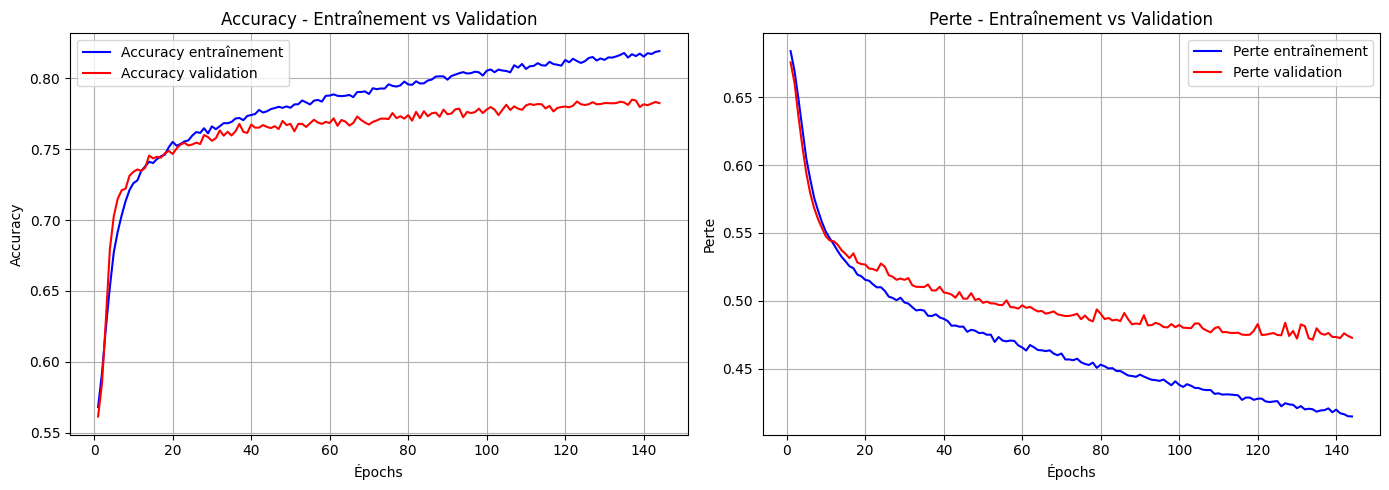

In [7]:
plot_training_history(history_ann)

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
Accuracy: 0.7834
Precision: 0.7448
Recall: 0.7697
F1-Score: 0.7570
AUROC: 0.8566


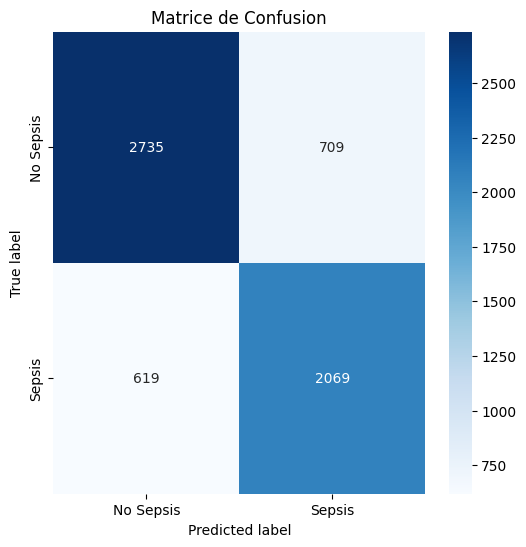

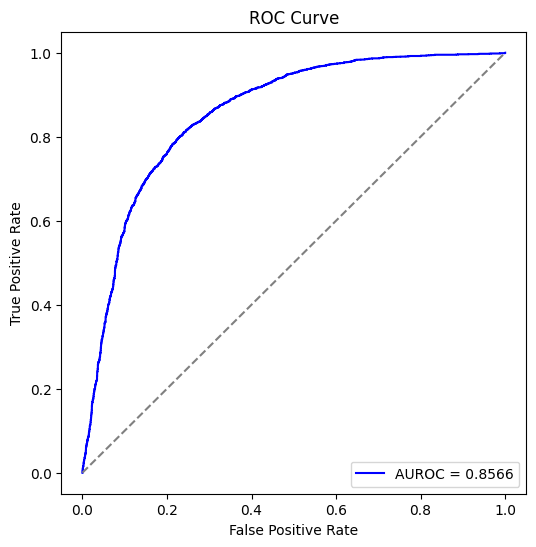

In [8]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_ann, normalize_sequences_test, labels_test)